[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1kR_TH2yNdowkIITaajbpJvKcJIdKivgG?authuser=2#scrollTo=v33M3Tt3ZC6V)

# Import

In [3]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# AdaFair

In [ ]:
# Implement algorithm: AdaFair 
# Research : AdaFair Cumulative Fairness Adaptive Boosting (Vasileios Iosifidis, Erini Ntoutsi)

class AdaFair(AdaBoostClassifier):

    def __init__(self,
                 base_estimator = None,
                 n_estimators = 10,
                 learning_rate = 1.,
                 algorithm = 'SAMME',
                 X_test = None,
                 y_test = None,
                 Sensitive_Idx = None,   ### Set Index of sensitive attribute (idx. col)
                 Sensitive_Val = None,   ### Set protected value in sensitive attribute as 1
                 c = 1,
                 random_state = None):
      
      super(AdaFair, self).__init__(
          base_estimator = base_estimator,
          n_estimators = n_estimators,
          learning_rate = learning_rate,
          random_state = random_state)
      
      self.algorithm = algorithm
      self.X_test = X_test
      self.y_test = y_test
      self.Sensitive_Idx = Sensitive_Idx 
      self.Sensitive_Val = Sensitive_Val
      self.c = c   
      self.estimator_alphas_ = np.zeros(self.n_estimators, dtype=np.float64)

      # Set for (1 + u)
      self.protect_pos = 1
      self.non_protect_pos = 1
      self.protect_neg = 1
      self.non_protect_neg = 1
# ---------------------------------------------------------------------------------------------------------------------------------   

    def compute_fairness(self, data, target, predict):

      #Separate protected and non-protected group
      y_true_p, y_true_np = [], []
      y_pred_p, y_pred_np = [], []

      idx_sensitive = data[:, self.Sensitive_Idx]         

      for y_true_i, y_pred_i, protect_i in zip(target, predict, idx_sensitive):
        if protect_i == self.Sensitive_Val:
          y_true_p.append(y_true_i)
          y_pred_p.append(y_pred_i)
        #elif protect_i == 0:
        else:
          y_true_np.append(y_true_i)
          y_pred_np.append(y_pred_i)
        #else:
          #return 0,0,0,0

      y_true_p = np.array(y_true_p)
      y_true_np = np.array(y_true_np)
      y_pred_p = np.array(y_pred_p)
      y_pred_np = np.array(y_pred_np)

      tn_p = confusion_matrix(y_true_p, y_pred_p)[0][0]
      fp_p = confusion_matrix(y_true_p, y_pred_p)[0][1]
      fn_p = confusion_matrix(y_true_p, y_pred_p)[1][0]
      tp_p = confusion_matrix(y_true_p, y_pred_p)[1][1]

      fpr_p = fp_p / (fp_p + tn_p)
      fnr_p = fn_p / (fn_p + tp_p)

      #print(1-fpr_p, 1-fnr_p)
        
      tn_np = confusion_matrix(y_true_np, y_pred_np)[0][0]
      fp_np = confusion_matrix(y_true_np, y_pred_np)[0][1]
      fn_np = confusion_matrix(y_true_np, y_pred_np)[1][0]
      tp_np = confusion_matrix(y_true_np, y_pred_np)[1][1]

      fpr_np = fp_np / (fp_np + tn_np)
      fnr_np = fn_np / (fn_np + tp_np)

      #print(1-fpr_np, 1-fnr_np)

      diff_fnr = fnr_np - fnr_p
      diff_fpr = fpr_np - fpr_p

      # Update factor (1 + u)
      if diff_fnr > 0:
        self.non_protect_pos = 1 + abs(diff_fnr)
      if diff_fnr < 0:
        self.protect_pos = 1 + abs(diff_fnr)
      if diff_fpr > 0:
        self.non_protect_neg = 1 + abs(diff_fpr)
      if diff_fpr < 0:
        self.protect_neg = 1 + abs(diff_fpr)

      fairness = abs(diff_fpr) + abs(diff_fnr)

      return fairness
# --------------------------------------------------------------------------------------------------------------------------------- 

    def fit(self, X_train, y_train, sample_weight = None):
      return super(AdaFair, self).fit(X_train, y_train, sample_weight)
# ---------------------------------------------------------------------------------------------------------------------------------   

    def _boost(self, iboost, X, y, sample_weight, random_state):
      #print(X[:, self.Sensitive_Idx])
      return self._minor_boost(iboost, X, y, sample_weight, random_state)
# --------------------------------------------------------------------------------------------------------------------------------- 

    def _minor_boost(self, iboost, X, y, sample_weight, random_state):      
      estimator = self._make_estimator(random_state = random_state)
      estimator.fit(X, y, sample_weight = sample_weight)
      y_pred = estimator.predict(X)
      y_prob = estimator.predict_proba(X)

      #print(y)
      #print(y_pred)

      if iboost == 0:
        self.classes_ = getattr(estimator, 'classes_', None)
        self.n_classes_ = len(self.classes_)      
      n_classes = self.n_classes_

      # Error
      y_pred_incorrect = y_pred != y
      error = np.mean(np.average(y_pred_incorrect, weights = sample_weight, axis = 0))

      if error <= 0:
        return sample_weight, 1, 0
      if error >= 1 - (1 / n_classes):
        self.estimators_.pop(-1)
        return None, None, None

      # Compute the weight
      alpha = 0.5 * np.log(((1 - error) / error))     
      self.estimator_alphas_[iboost] = alpha   
     
      if iboost != 0:
        fairness = self.compute_fairness(X, y, y_pred)
      else:
        fairness = 1

      #tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
      #tpr = tp / (tp + fn)
      #tnr = tn / (tn + fp)
      
      # Update sample weight
      col_sensitive = X[:, self.Sensitive_Idx]         
      col_val_protect = self.Sensitive_Val
                           
      if not (iboost == self.n_estimators - 1):
        for i, row in enumerate(sample_weight):

          if y[i] == 1 and y_pred[i] != 1:
            if col_sensitive[i] == col_val_protect:
              sample_weight[i] *= self.protect_pos * np.exp(alpha * max(y_prob[i][0], y_prob[i][1]))
            else:
              sample_weight[i] *= self.non_protect_pos * np.exp( alpha * max(y_prob[i][0], y_prob[i][1]))

          elif y[i] == -1 and y_pred[i] != -1:
            if col_sensitive[i] == col_val_protect:
              sample_weight[i] *= self.protect_neg * np.exp(alpha * max(y_prob[i][0], y_prob[i][1]))
            else:
              sample_weight[i] *= self.non_protect_neg * np.exp( alpha * max(y_prob[i][0], y_prob[i][1]))

      return sample_weight, alpha, error
# --------------------------------------------------------------------------------------------------------------------------------- 

    def predict(self, X_test):
      n_classes = self.n_classes_
      classes = self.classes_[:, np.newaxis]

      pred = self.compute_prediction(X_test)

      if n_classes == 2:
        return self.classes_.take(pred > 0, axis = 0)

      return self.classes_.take(np.argmax(pred, axis = 1), axis = 0)
# ---------------------------------------------------------------------------------------------------------------------------------    

    def compute_prediction(self, X):
      n_classes = self.n_classes_
      classes = self.classes_[:, np.newaxis]

      predict_sum = np.sum(np.transpose(estimator.predict(X) == classes) * w  for estimator, w in zip(self.estimators_, self.estimator_alphas_))
      predict_sum /= np.sum(self.estimator_alphas_)

      if n_classes == 2:
        predict_sum[:, 0] *= -1
        return predict_sum.sum(axis = 1)
        
      return predict_sum


# Function score_model

Function for calculating balance accuracy, accuracy, equalized Odds, TPR protected, TPR non-protected, TNR-protected, TNR-non-protected

In [ ]:
def score_model(X_test, y_true, y_pred, Sensitive_Idx = None, Sensitive_Val = None):

  y_true_p, y_true_np = [], []
  y_pred_p, y_pred_np = [], []

  idx_sensitive = X_test.iloc[:, Sensitive_Idx]        

  for y_true_i, y_pred_i, protect_i in zip(y_true, y_pred, idx_sensitive):
    if protect_i == Sensitive_Val:
      y_true_p.append(y_true_i)
      y_pred_p.append(y_pred_i)
    else:
      y_true_np.append(y_true_i)
      y_pred_np.append(y_pred_i)

  y_true_p = np.array(y_true_p)
  y_true_np = np.array(y_true_np)
  y_pred_p = np.array(y_pred_p)
  y_pred_np = np.array(y_pred_np)

  tn_p = confusion_matrix(y_true_p, y_pred_p)[0][0]
  fp_p = confusion_matrix(y_true_p, y_pred_p)[0][1]
  fn_p = confusion_matrix(y_true_p, y_pred_p)[1][0]
  tp_p = confusion_matrix(y_true_p, y_pred_p)[1][1]

  fpr_p = fp_p / (fp_p + tn_p)
  fnr_p = fn_p / (fn_p + tp_p)
        
  tn_np = confusion_matrix(y_true_np, y_pred_np)[0][0]
  fp_np = confusion_matrix(y_true_np, y_pred_np)[0][1]
  fn_np = confusion_matrix(y_true_np, y_pred_np)[1][0]
  tp_np = confusion_matrix(y_true_np, y_pred_np)[1][1]

  fpr_np = fp_np / (fp_np + tn_np)
  fnr_np = fn_np / (fn_np + tp_np)

  diff_fnr = fnr_np - fnr_p
  diff_fpr = fpr_np - fpr_p

  # Scores
  bal_score = balanced_accuracy_score(y_true, y_pred)
  acc_score = accuracy_score(y_true, y_pred)
  eq_odds = abs(diff_fpr) + abs(diff_fnr)
  tpr_protect = 1 - fnr_p
  tpr_non_protect = 1 - fnr_np
  tnr_protect = 1 - fpr_p
  tnr_non_protect = 1 - fpr_np

  return [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]

# Dataset: Adult Census Income

Preparing dataset

In [ ]:
df_adult = pd.read_csv('adult.csv')
df_adult.shape

(32561, 15)

In [ ]:
df_adult['sex'].value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

In [ ]:
print(f'Class ratio adult dataset\nFemale : Male = 1 : {21790/10771}')

Class ratio adult dataset
Female : Male = 1 : 2.0230247887846997


In [ ]:
# Delete NaN
df_adult.replace('?', np.nan, inplace=True)
df_adult.dropna(axis=0, inplace=True)

# Delete col fnlwgt
df_adult.drop('fnlwgt', axis=1, inplace=True)

# Define target value
df_adult['income'].replace('<=50K', 0, inplace=True)
df_adult['income'].replace('>50K', 1, inplace=True)

In [ ]:
y = df_adult['income']
X = df_adult.drop('income', axis=1)

X['sex'].replace('Male', 0, inplace=True)
X['sex'].replace('Female', 1, inplace=True)

X = pd.get_dummies(X)
X.head(3)

,age,education.num,sex,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native.country_Cambodia,native.country_Canada,native.country_China,native.country_Columbia,native.country_Cuba,native.country_Dominican-Republic,native.country_Ecuador,native.country_El-Salvador,native.country_England,native.country_France,native.country_Germany,native.country_Greece,native.country_Guatemala,native.country_Haiti,native.country_Holand-Netherlands,native.country_Honduras,native.country_Hong,native.country_Hungary,native.country_India,native.country_Iran,native.country_Ireland,native.country_Italy,native.country_Jamaica,native.country_Japan,native.country_Laos,native.country_Mexico,native.country_Nicaragua,native.country_Outlying-US(Guam-USVI-etc),native.country_Peru,native.country_Philippines,native.country_Poland,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
1,82,9,1,0,4356,18,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,54,4,1,0,3900,40,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,41,10,1,0,3900,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

col_num_adult = ['age',	'education.num',	'capital.gain',	'capital.loss',	'hours.per.week']

scaler = StandardScaler()
scaler.fit(X_train[col_num_adult])
X_train[col_num_adult] = scaler.transform(X_train[col_num_adult])
X_test[col_num_adult] = scaler.transform(X_test[col_num_adult])

Train AdaFair

In [ ]:
# Using DecisionTreeClassifier as base model
# Protect 'sex' column

adaf = AdaFair(base_estimator = DecisionTreeClassifier(max_depth=5),
               random_state=0,
               Sensitive_Idx=2, Sensitive_Val=1)

adaf.fit(X_train, y_train)
y_pred_adult = adaf.predict(X_test)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_adult_adf = score_model(X_test, y_test, y_pred_adult, Sensitive_Idx = 2, Sensitive_Val = 1)
score_adult_adf

[0.8124889755197087,
 0.7798651784727594,
 0.4172164886783738,
 0.7620481927710844,
 0.8973958333333334,
 0.9206712433257056,
 0.6388023952095808]

Train AdaBoost

In [ ]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=0), algorithm="SAMME", n_estimators=10, random_state=0)

adab.fit(X_train, y_train)
y_pred_adult = adab.predict(X_test)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_adult_adb = score_model(X_test, y_test, y_pred_adult, Sensitive_Idx = 2, Sensitive_Val = 1)
score_adult_adb

[0.7840824993055394,
 0.8493756216156482,
 0.20567464791956713,
 0.5572289156626506,
 0.6708333333333334,
 0.9706331045003814,
 0.878562874251497]

Plot

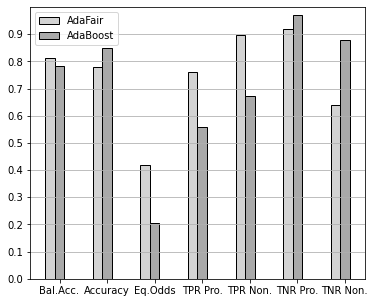

In [ ]:
barWidth = 0.2
fig = plt.subplots(figsize =(6, 5))

br1 = np.arange(len(score_adult_adf))
br2 = [x + barWidth for x in br1]

plt.bar(br1, score_adult_adf, color ='lightgray', width = barWidth, edgecolor ='k', label ='AdaFair')
plt.bar(br2, score_adult_adb, color ='darkgray', width = barWidth, edgecolor ='k', label ='AdaBoost')

plt.xticks([r + barWidth for r in range(len(score_adult_adf))],
           ['Bal.Acc.', 'Accuracy', 'Eq.Odds', 'TPR Pro.', 'TPR Non.', 'TNR Pro.', 'TNR Non.'])
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.grid(axis = 'y');

# Dataset: Bank

Preparing dataset

In [ ]:
df_bank = pd.read_csv('bank.csv')
df_bank.shape

(49732, 17)

In [ ]:
df_bank['marital'].value_counts()

married     30011
single      13986
divorced     5735
Name: marital, dtype: int64

In [ ]:
print(f'Class ratio bank dataset\nmarried : others = 1 : {30011/(13986+5735)}')

Class ratio bank dataset
married : others = 1 : 1.5217788144617412


In [ ]:
#df_bank.dropna(axis=0, inplace=True)
y_bank = df_bank['y']
X_bank = df_bank.drop('y', axis=1)

X_bank = pd.get_dummies(X_bank)

X_train_bank, X_test_bank, y_train_bank, y_test_bank = train_test_split(X_bank, y_bank, test_size=0.3, stratify=y_bank, random_state=0)

col_num_bank = ['age',	'balance',	'day',	'duration',	'campaign',	'pdays',	'previous']
scaler = StandardScaler()
scaler.fit(X_train_bank[col_num_bank])

X_train_bank[col_num_bank] = scaler.transform(X_train_bank[col_num_bank])
X_test_bank[col_num_bank] = scaler.transform(X_test_bank[col_num_bank])
X_train_bank.head(3)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
32546,-1.033927,-0.363123,0.142990,0.139178,-0.572502,2.368087,0.593359,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9924,1.418289,-0.064173,-0.820389,-0.649796,0.076904,-0.407303,-0.238237,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
640,1.323973,-0.372516,-1.181656,0.271321,-0.247799,-0.407303,-0.238237,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Train AdaFair

In [ ]:
# Using DecisionTreeClassifier as base model
# Protect 'marital_married' column
adaf = AdaFair(base_estimator = DecisionTreeClassifier(max_depth=5, random_state=0),
               random_state=0,
               Sensitive_Idx=20, Sensitive_Val=1)

adaf.fit(X_train_bank, y_train_bank)
y_pred_bank = adaf.predict(X_test_bank)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_bank_adf = score_model(X_test_bank, y_test_bank, y_pred_bank, Sensitive_Idx = 20, Sensitive_Val = 1)
score_bank_adf

[0.663885999662741,
 0.9009383378016086,
 0.02561171873714858,
 0.3482142857142857,
 0.36127508854781587,
 0.9780409573155687,
 0.9654900414119503]

Train AdaBoost

In [ ]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=0), algorithm="SAMME", n_estimators=10)

adab.fit(X_train_bank, y_train_bank)
y_pred_bank = adab.predict(X_test_bank)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_bank_adb = score_model(X_test_bank, y_test_bank, y_pred_bank, Sensitive_Idx = 20, Sensitive_Val = 1)
score_bank_adb

[0.6415350797045444,
 0.8983914209115281,
 0.018982877088770837,
 0.3125,
 0.2998819362455726,
 0.9791512459906242,
 0.9727864326562808]

# Dataset: Compas

Preparing dataset

In [ ]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df_compas = pd.read_csv(url)
df_compas.shape

(7214, 53)

In [ ]:
df_compas['sex'].value_counts()

Male      5819
Female    1395
Name: sex, dtype: int64

In [ ]:
print(f'Class ratio compas dataset\nFemale : Male = 1 : {5819/1395}')

Class ratio compas dataset
Female : Male = 1 : 4.171326164874552


In [ ]:
drop_col_compas = ['id', 'name', 'first', 'last', 'compas_screening_date', 'dob', 'c_case_number', 'c_charge_desc', 'violent_recid', 'is_violent_recid',
                   'c_jail_in',	'c_jail_out', 'c_case_number',	'c_offense_date',	'c_arrest_date', 'c_charge_desc', 'days_b_screening_arrest',
                   'r_case_number',	'r_charge_degree',	'r_days_from_arrest',	'r_offense_date',	'r_charge_desc',	'r_jail_in',	'r_jail_out', 'vr_case_number', 
                   'vr_charge_degree',	'vr_offense_date',	'vr_charge_desc', 'screening_date', 'v_screening_date',	'in_custody',	'out_custody']

df_compas.drop(drop_col_compas, axis=1, inplace=True)
df_compas['c_days_from_compas'].replace(np.NaN, 0, inplace=True)

y_compas = df_compas['two_year_recid']
X_compas = df_compas.drop('two_year_recid', axis=1)

X_compas['sex'].replace('Male', 0, inplace=True)
X_compas['sex'].replace('Female', 1, inplace=True)

X_compas = pd.get_dummies(X_compas)

In [ ]:
X_train_compas, X_test_compas, y_train_compas, y_test_compas = train_test_split(X_compas, y_compas, test_size=0.3, stratify=y_compas, random_state=0)

col_num_compas = ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_days_from_compas',
                    'is_recid', 'decile_score.1', 'v_decile_score', 'priors_count.1', 'start', 'end']

scaler = StandardScaler()
scaler.fit(X_train_compas[col_num_compas])
X_train_compas[col_num_compas] = scaler.transform(X_train_compas[col_num_compas])
X_test_compas[col_num_compas] = scaler.transform(X_test_compas[col_num_compas])
X_train_compas.head(3)

,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,is_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,v_type_of_assessment_Risk of Violence,v_score_text_High,v_score_text_Low,v_score_text_Medium
2744,0,2.031108,-0.134558,-1.243271,-0.193948,-0.226813,-0.713343,-0.165402,-0.962860,-1.243271,-1.080833,-0.713343,-0.24526,1.292227,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0
4641,0,-0.811969,3.781190,1.924048,7.024070,-0.226813,0.961463,-0.026951,-0.962860,1.924048,2.085930,0.961463,-0.24526,-0.052969,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0
3695,1,0.609569,-0.134558,-1.243271,-0.193948,-0.226813,-0.713343,-0.162392,1.038573,-1.243271,-1.080833,-0.713343,-0.24526,-0.925596,1,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0


Train AdaFair

In [ ]:
# Using DecisionTreeClassifier as base model
# Protect 'sex' column
adaf = AdaFair(base_estimator = DecisionTreeClassifier(max_depth=5, random_state=0),
               random_state=0,
               Sensitive_Idx=0, Sensitive_Val=1)

adaf.fit(X_train_compas, y_train_compas)
y_pred_compas = adaf.predict(X_test_compas)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_compas_adf = score_model(X_test_compas, y_test_compas, y_pred_compas, Sensitive_Idx = 0, Sensitive_Val = 1)
score_compas_adf

[0.9945332211942809,
 0.9939953810623556,
 0.004642696773365835,
 1.0,
 1.0,
 0.9926470588235294,
 0.9880043620501636]

Train AdaBoost

In [ ]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=0), algorithm="SAMME", n_estimators=10)

adab.fit(X_train_compas, y_train_compas)
y_pred_compas = adab.predict(X_test_compas)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_compas_adb = score_model(X_test_compas, y_test_compas, y_pred_compas, Sensitive_Idx = 0, Sensitive_Val = 1)
score_compas_adb

[0.9916964248783245,
 0.9916859122401848,
 0.008591189577954262,
 0.9856115107913669,
 0.992831541218638,
 0.9926470588235294,
 0.9912758996728462]

# Dataset: KDD census income

Preparing dataset

In [ ]:
df_kdd = pd.read_csv('KDD.txt', header = None)
header_list = ['age', 'class_worker', 'ind_code', 'occ_code', 'education', 
               'wage_per_hour', 'enrolled_last_wk', 'marital_status', 'major_ind_code', 'major_occ_code',
               'mace', 'hispanic_Origin', 'sex', 'member_labor_union', 'reason_unemploy',
               'full_or_parttime', 'capital_gains', 'capital_losses', 'divdends_stocks', 'tax_filer_status',
               'region_pv_residence', 'state_pv_residence', 'detailed_family_stat', 'detailed_summary_household', 'instance_weight', 
               'migration_code_change_msa', 'migration_code_change_reg', 'migration_code_move_within_reg', 'live_in_house_1year_ago', 'migration_pv_res_in_sunbelt',
               'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self',
               'citizenship', 'total_person_income', 'own_bus_or_self_employed', 'total_person_earnings', 'weeks_worked_in_year',
               'veterans_benefits', 'income']
df_kdd.columns = header_list
df_kdd.shape

(199523, 42)

In [ ]:
df_kdd['sex'].value_counts()

 Female    103984
 Male       95539
Name: sex, dtype: int64

In [ ]:
print(f'Class ratio KDD dataset\nFemale : Male = {103984/95539}:1')

Class ratio KDD dataset
Female : Male = 1.0883932216163033:1


In [ ]:
df_kdd.replace(' ?', np.nan, inplace=True)
df_kdd.iloc[:, 21].replace(np.nan, 'NoData', inplace=True)
df_kdd.iloc[:, 25].replace(np.nan, 'NoData', inplace=True)
df_kdd.iloc[:, 26].replace(np.nan, 'NoData', inplace=True)
df_kdd.iloc[:, 27].replace(np.nan, 'NoData', inplace=True)
df_kdd.iloc[:, 29].replace(np.nan, 'NoData', inplace=True)

df_kdd.dropna(axis=0, inplace=True)

df_kdd['income'].replace(' - 50000.', 0, inplace=True)
df_kdd['income'].replace(' 50000+.', 1, inplace=True)

df_kdd['sex'].replace(' Male', 0, inplace=True)
df_kdd['sex'].replace(' Female', 1, inplace=True)

df_kdd['ind_code'] = df_kdd['ind_code'].astype(str)
df_kdd['occ_code'] = df_kdd['ind_code'].astype(str)
df_kdd['veterans_benefits'] = df_kdd['veterans_benefits'].astype(str)

df_kdd.shape

(191239, 42)

In [ ]:
y_kdd = df_kdd['income']
X_kdd = df_kdd.drop('income', axis=1)
X_kdd.head(3)

,age,class_worker,ind_code,occ_code,education,wage_per_hour,enrolled_last_wk,marital_status,major_ind_code,major_occ_code,mace,hispanic_Origin,sex,member_labor_union,reason_unemploy,full_or_parttime,capital_gains,capital_losses,divdends_stocks,tax_filer_status,region_pv_residence,state_pv_residence,detailed_family_stat,detailed_summary_household,instance_weight,migration_code_change_msa,migration_code_change_reg,migration_code_move_within_reg,live_in_house_1year_ago,migration_pv_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,total_person_income,own_bus_or_self_employed,total_person_earnings,weeks_worked_in_year,veterans_benefits
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,1,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,NoData,NoData,NoData,Not in universe under 1 year old,NoData,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95
1,58,Self-employed-not incorporated,4,4,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,0,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,1,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,NoData,NoData,NoData,Not in universe under 1 year old,NoData,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95


In [ ]:
X_kdd = pd.get_dummies(X_kdd)
X_kdd.head(3)

,age,wage_per_hour,sex,capital_gains,capital_losses,divdends_stocks,instance_weight,num_persons_worked_for_employer,total_person_income,total_person_earnings,weeks_worked_in_year,class_worker_ Federal government,class_worker_ Local government,class_worker_ Never worked,class_worker_ Not in universe,class_worker_ Private,class_worker_ Self-employed-incorporated,class_worker_ Self-employed-not incorporated,class_worker_ State government,class_worker_ Without pay,ind_code_0,ind_code_1,ind_code_10,ind_code_11,ind_code_12,ind_code_13,ind_code_14,ind_code_15,ind_code_16,ind_code_17,ind_code_18,ind_code_19,ind_code_2,ind_code_20,ind_code_21,ind_code_22,ind_code_23,ind_code_24,ind_code_25,ind_code_26,ind_code_27,ind_code_28,ind_code_29,ind_code_3,ind_code_30,ind_code_31,ind_code_32,ind_code_33,ind_code_34,ind_code_35,ind_code_36,ind_code_37,ind_code_38,ind_code_39,ind_code_4,ind_code_40,ind_code_41,ind_code_42,ind_code_43,ind_code_44,ind_code_45,ind_code_46,ind_code_47,ind_code_48,ind_code_49,ind_code_5,ind_code_50,ind_code_51,ind_code_6,ind_code_7,ind_code_8,ind_code_9,occ_code_0,occ_code_1,occ_code_10,occ_code_11,occ_code_12,occ_code_13,occ_code_14,occ_code_15,occ_code_16,occ_code_17,occ_code_18,occ_code_19,occ_code_2,occ_code_20,occ_code_21,occ_code_22,occ_code_23,occ_code_24,occ_code_25,occ_code_26,occ_code_27,occ_code_28,occ_code_29,occ_code_3,occ_code_30,occ_code_31,occ_code_32,occ_code_33,occ_code_34,occ_code_35,occ_code_36,occ_code_37,occ_code_38,occ_code_39,occ_code_4,occ_code_40,occ_code_41,occ_code_42,occ_code_43,occ_code_44,occ_code_45,occ_code_46,occ_code_47,occ_code_48,occ_code_49,occ_code_5,occ_code_50,occ_code_51,occ_code_6,occ_code_7,occ_code_8,occ_code_9,education_ 10th grade,education_ 11th grade,education_ 12th grade no diploma,education_ 1st 2nd 3rd or 4th grade,education_ 5th or 6th grade,education_ 7th and 8th grade,education_ 9th grade,education_ Associates degree-academic program,education_ Associates degree-occup /vocational,education_ Bachelors degree(BA AB BS),education_ Children,education_ Doctorate degree(PhD EdD),education_ High school graduate,education_ Less than 1st grade,education_ Masters degree(MA MS MEng MEd MSW MBA),education_ Prof school degree (MD DDS DVM LLB JD),education_ Some college but no degree,enrolled_last_wk_ College or university,enrolled_last_wk_ High school,enrolled_last_wk_ Not in universe,marital_status_ Divorced,marital_status_ Married-A F spouse present,marital_status_ Married-civilian spouse present,marital_status_ Married-spouse absent,marital_status_ Never married,marital_status_ Separated,marital_status_ Widowed,major_ind_code_ Agriculture,major_ind_code_ Armed Forces,major_ind_code_ Business and repair services,major_ind_code_ Communications,major_ind_code_ Construction,major_ind_code_ Education,major_ind_code_ Entertainment,major_ind_code_ Finance insurance and real estate,major_ind_code_ Forestry and fisheries,major_ind_code_ Hospital services,major_ind_code_ Manufacturing-durable goods,major_ind_code_ Manufacturing-nondurable goods,major_ind_code_ Medical except hospital,major_ind_code_ Mining,major_ind_code_ Not in universe or children,major_ind_code_ Other professional services,major_ind_code_ Personal services except private HH,major_ind_code_ Private household services,major_ind_code_ Public administration,major_ind_code_ Retail trade,major_ind_code_ Social services,major_ind_code_ Transportation,major_ind_code_ Utilities and sanitary services,major_ind_code_ Wholesale trade,major_occ_code_ Adm support including clerical,major_occ_code_ Armed Forces,major_occ_code_ Executive admin and managerial,major_occ_code_ Farming forestry and fishing,major_occ_code_ Handlers equip cleaners etc,major_occ_code_ Machine operators assmblrs & inspctrs,major_occ_code_ Not in universe,major_occ_code_ Other service,major_occ_code_ Precision production craft & repair,major_occ_code_ Private household services,major_occ_code_ Professional specialty,major_occ_code_ Protective services,maj

In [ ]:
X_train_kdd, X_test_kdd, y_train_kdd, y_test_kdd = train_test_split(X_kdd, y_kdd, test_size=0.3, stratify=y_kdd, random_state=0)

col_num_kdd = ['age',	'wage_per_hour',	'capital_gains',	'capital_losses',	'divdends_stocks',	'instance_weight',	
                  'num_persons_worked_for_employer',	'total_person_income',	'total_person_earnings',	'weeks_worked_in_year']

scaler = StandardScaler()
scaler.fit(X_train_kdd[col_num_kdd])
X_train_kdd[col_num_kdd] = scaler.transform(X_train_kdd[col_num_kdd])
X_test_kdd[col_num_kdd] = scaler.transform(X_test_kdd[col_num_kdd])

Train AdaFair

In [ ]:
# Using DecisionTreeClassifier as base model
# Protect 'sex' column
adaf = AdaFair(base_estimator = DecisionTreeClassifier(max_depth=5, random_state=0),
               random_state=0,
               Sensitive_Idx=2, Sensitive_Val=1)

adaf.fit(X_train_kdd, y_train_kdd)
y_pred_kdd = adaf.predict(X_test_kdd)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_kdd_adf = score_model(X_test_kdd, y_test_kdd, y_pred_kdd, Sensitive_Idx = 2, Sensitive_Val = 1)
score_kdd_adf

[0.843211918270401,
 0.8763856933695879,
 0.28784112435721687,
 0.674025974025974,
 0.8423357664233577,
 0.9361093889922161,
 0.8165780570323828]

Train AdaBoost

In [ ]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=0), algorithm="SAMME", n_estimators=10)

adab.fit(X_train_kdd, y_train_kdd)
y_pred_kdd = adab.predict(X_test_kdd)

# score list [bal_score, acc_score, eq_odds, tpr_protect, tpr_non_protect, tnr_protect, tnr_non_protect]
score_kdd_adb = score_model(X_test_kdd, y_test_kdd, y_pred_kdd, Sensitive_Idx = 2, Sensitive_Val = 1)
score_kdd_adb

[0.6823626190006941,
 0.9504287805898347,
 0.2081001396351615,
 0.22597402597402594,
 0.4193430656934306,
 0.9945925466694221,
 0.9798614467536653]